In [21]:
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import seaborn as sns
import matplotlib.pyplot as plt

In [22]:
df = pd.read_csv('../data/bank_reviews.csv')

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1648 entries, 0 to 1647
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   review  1648 non-null   object
 1   rating  1648 non-null   int64 
 2   date    1648 non-null   object
 3   bank    1648 non-null   object
 4   source  1648 non-null   object
dtypes: int64(1), object(4)
memory usage: 64.5+ KB


### Sentiment Analysis using VADER

In [35]:
analyzer = SentimentIntensityAnalyzer()

# Define function to classify sentiment
def get_sentiment_label(score):
    if score >= 0.05:
        return "positive"
    elif score <= -0.05:
        return "negative"
    else:
        return "neutral"

# Apply VADER
df["compound_score"] = df["review"].apply(lambda x: analyzer.polarity_scores(str(x))["compound"])
df["vader_sentiment"] = df["compound_score"].apply(get_sentiment_label)

df[["review", "compound_score", "vader_sentiment"]]


,review,compound_score,vader_sentiment
0,the app is proactive and a good connections.,0.6908,positive
1,I cannot send to cbebirr app. through this app.,0.0000,neutral
2,good,0.4404,positive
3,not functional,0.0000,neutral
4,everytime you uninstall the app you have to re...,0.1739,positive
...,...,...,...
1643,Best,0.6369,positive
1644,"Waw Great and innovated,user friendly, always ...",0.8074,positive
1645,It's Best waww 🙏,0.6369,positive
1646,Always one step ahead,0.0000,neutral


In [36]:
# Mean compound score by bank and rating
summary = df.groupby(["bank", "rating"])["compound_score"].mean().reset_index()

# Count of sentiment labels per bank
sentiment_count = df.groupby(["bank", "vader_sentiment"]).size().reset_index(name="count")

summary, sentiment_count


(                           bank  rating  compound_score
 0             Bank of Abyssinia       1       -0.174007
 1             Bank of Abyssinia       2       -0.018022
 2             Bank of Abyssinia       3        0.195535
 3             Bank of Abyssinia       4        0.287791
 4             Bank of Abyssinia       5        0.340090
 5   Commercial Bank of Ethiopia       1       -0.033566
 6   Commercial Bank of Ethiopia       2        0.064595
 7   Commercial Bank of Ethiopia       3        0.123031
 8   Commercial Bank of Ethiopia       4        0.314567
 9   Commercial Bank of Ethiopia       5        0.420969
 10                  Dashen Bank       1       -0.043218
 11                  Dashen Bank       2       -0.085565
 12                  Dashen Bank       3        0.303873
 13                  Dashen Bank       4        0.322442
 14                  Dashen Bank       5        0.539752,
                           bank vader_sentiment  count
 0            Bank of Abyssinia 

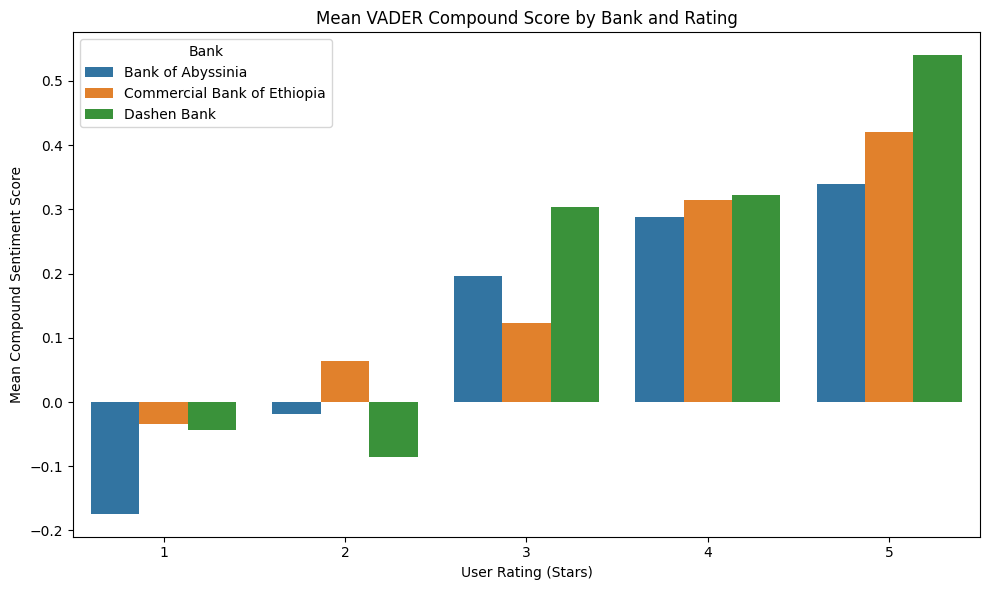

In [37]:
plt.figure(figsize=(10, 6))
sns.barplot(data=summary, x="rating", y="compound_score", hue="bank")

plt.title("Mean VADER Compound Score by Bank and Rating")
plt.xlabel("User Rating (Stars)")
plt.ylabel("Mean Compound Sentiment Score")
plt.legend(title="Bank")
plt.tight_layout()
plt.show()

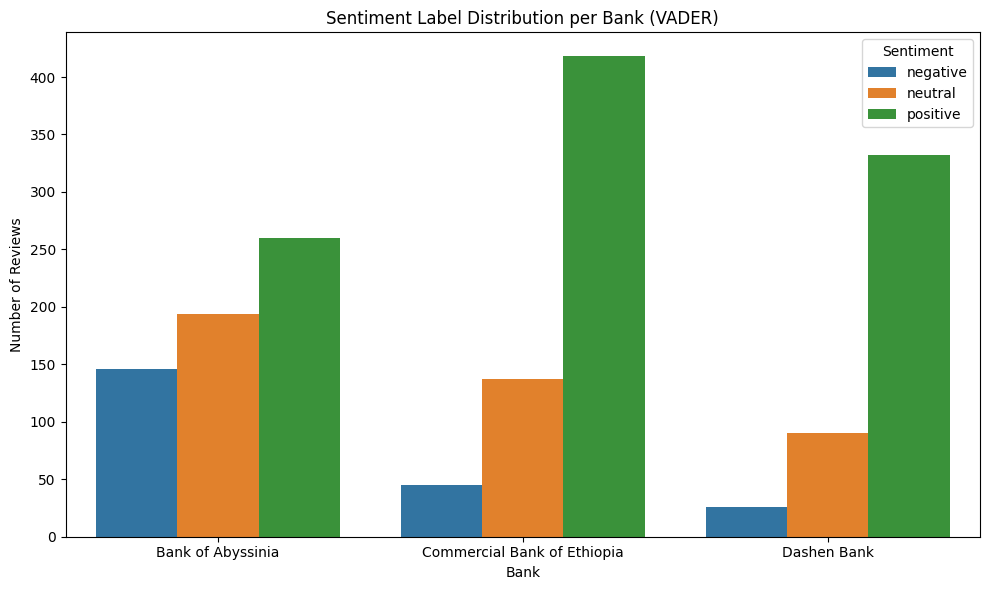

In [38]:
plt.figure(figsize=(10, 6))
sns.barplot(data=sentiment_count, x="bank", y="count", hue="vader_sentiment")

plt.title("Sentiment Label Distribution per Bank (VADER)")
plt.xlabel("Bank")
plt.ylabel("Number of Reviews")
plt.legend(title="Sentiment")
plt.tight_layout()
plt.show()


### Sentiment Analysis using distilbert-base-uncased-finetuned-sst-2-english

In [42]:
df2 = pd.read_csv("../data/bank_reviews.csv")

In [50]:
from transformers import pipeline
from tqdm import tqdm

# Load sentiment analysis pipeline
sentiment_pipeline = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")
# Truncate reviews to 512 characters and analyze sentiment
tqdm.pandas()  

df2["bert_result"] = df["review"].progress_apply(lambda x: sentiment_pipeline(str(x))[0])

Device set to use cpu
100%|██████████| 1648/1648 [00:58<00:00, 28.40it/s]


In [ ]:
bert_summary = df2.groupby(["bank", "rating"])["bert_sentiment"].value_counts().unstack().fillna(0)
print(bert_summary) 

bert_sentiment                      NEGATIVE  POSITIVE
bank                        rating                    
Bank of Abyssinia           1            237        24
                            2             21         2
                            3             24        19
                            4             11        11
                            5             61       190
Commercial Bank of Ethiopia 1             51        13
                            2             15         5
                            3             29         7
                            4             29        26
                            5             61       364
Dashen Bank                 1             32         2
                            2             15         2
                            3              6         5
                            4             12        12
                            5             39       323


In [48]:
sentiment_count = df2.groupby("bank")["bert_sentiment"].value_counts().unstack().fillna(0)
print(sentiment_count)

bert_sentiment               NEGATIVE  POSITIVE
bank                                           
Bank of Abyssinia                 354       246
Commercial Bank of Ethiopia       185       415
Dashen Bank                       104       344
